# CHILDES Chinese: Age vs MLU

In [6]:
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [7]:
# List of CSV files to process
mlu_files_50 = ['Kang_mlu50.csv', 'Laohu_mlu50.csv', 'Peng_mlu50.csv', 'Zhong_mlu50.csv', 'Cheng_mlu50.csv', 'Chou_mlu50.csv', 'Chw_mlu50.csv', 'Jc_mlu50.csv', 'Pan_mlu50.csv', 'Wang_mlu50.csv', 'Wu_mlu50.csv', 'Wuys_mlu50.csv', 'Xu_mlu50.csv', 'Yang_mlu50.csv', 'Tong_mlu50.csv', 'Zhou3_mlu50.csv']  # Uses _mlu50.csv files
mlu_files_100 = ['Kang_mlu100.csv', 'Laohu_mlu100.csv', 'Peng_mlu100.csv', 'Zhong_mlu100.csv', 'Cheng_mlu100.csv', 'Chou_mlu100.csv', 'Chw_mlu100.csv', 'Jc_mlu100.csv', 'Pan_mlu100.csv', 'Wang_mlu100.csv', 'Wu_mlu100.csv', 'Wuys_mlu100.csv', 'Xu_mlu100.csv', 'Yang_mlu100.csv', 'Tong_mlu100.csv', 'Zhou3_mlu100.csv']  # Uses _mlu100.csv files
mlu_files_all = ['Kang_mlu.csv', 'Laohu_mlu.csv', 'Peng_mlu.csv', 'Zhong_mlu.csv', 'Cheng_mlu.csv', 'Chou_mlu.csv', 'Chw_mlu.csv', 'Jc_mlu.csv', 'Pan_mlu.csv', 'Wang_mlu.csv', 'Wu_mlu.csv', 'Wuys_mlu.csv', 'Xu_mlu.csv', 'Yang_mlu.csv', 'Tong_mlu.csv', 'Zhou3_mlu.csv']  # Uses _mlu.csv files

# Initialize a 2D array to store Spearman's rho values for each CSV file
spearman_rhos_50 = []
spearman_rhos_100 = []
spearman_rhos_all = []

# Load the original _mlu.csv files to get ages (the other _mlu.csv files do not contain the corresponding ages for each transcript)
age_files = ['Kang_mlu.csv', 'Laohu_mlu.csv', 'Peng_mlu.csv', 'Zhong_mlu.csv', 'Cheng_mlu.csv', 'Chou_mlu.csv', 'Chw_mlu.csv', 'Jc_mlu.csv', 'Pan_mlu.csv', 'Wang_mlu.csv', 'Wu_mlu.csv', 'Wuys_mlu.csv', 'Xu_mlu.csv', 'Yang_mlu.csv', 'Tong_mlu.csv', 'Zhou3_mlu.csv']

In [8]:
def age_in_months(age_str):
    parts = age_str.split(';')
    if len(parts) == 2:  # Example Format: "2;11.28", "2;05.", or "3;"
        years = int(parts[0])
        months_and_days = parts[1].split('.')
        
        # Handle cases where days are not provided
        if months_and_days[0] == '':
            months = 0  # Assume 00 months if no months are provided
        else:
            months = float(months_and_days[0])
        
        # Check if the month format ends with a dot, indicating missing days
        if len(months_and_days) > 1 and months_and_days[1] == '':
            days = 0  # Assume 00 days if no days are provided
        else:
            days = float(months_and_days[1]) if len(months_and_days) > 1 else 0
        
        months += days / 30  # Keep decimal for days
        return years * 12 + months
    return 0  # Consider raising an error instead of returning 0 for invalid formats

In [9]:
def age_mlu_plots(mlu_files, spearman_rhos, age_files):
    age_data = {}

    for age_file in age_files:
        if os.path.exists(age_file):
            with open(age_file, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                data = list(reader)
                # Store ages in a dictionary with the base filename as the key
                for entry in data:
                    base_filename = entry['File'].split('.')[0]  # Get the base filename
                    age_data[base_filename] = age_in_months(entry['Age'])  # Store the age

    for mlu_file in mlu_files:
        # Check if the file exists before attempting to open it
        if os.path.exists(mlu_file):
            with open(mlu_file, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                data = list(reader)

            # Initialize list to hold chosen transcripts
            chosen_transcripts = []
            transcript_list = []
            time_steps = []  # New list to hold time steps

            # Select the first transcript
            if data:  # Check if there is any data
                first_data = data[0]
                # Extract the base filename to get the corresponding age
                base_filename = first_data['File'].split('.')[0]
                first_age = age_data.get(base_filename, 0)  # Get the corresponding age or default to 0
                chosen_transcripts.append((first_age, float(first_data['morphemes/utterances'])))
                transcript_list.append(first_data['File'])  # Collect the first transcript name

                last_chosen_age = first_age

                # Select subsequent transcripts that are at least 1 month apart
                for entry in data[1:]:  # Start from the second transcript
                    base_filename = entry['File'].split('.')[0]
                    current_age = age_data.get(base_filename, 0)  # Get the corresponding age or default to 0
                    if current_age - last_chosen_age >= 1:
                        chosen_transcripts.append((current_age, float(entry['morphemes/utterances'])))  # Collect age and morphemes/utterances
                        transcript_list.append(entry['File'])  # Collect the transcript name
                        time_steps.append(current_age - last_chosen_age)  # Calculate time step without rounding
                        last_chosen_age = current_age

            # Plot Age vs Morphemes/Utterances
            ages = [t[0] for t in chosen_transcripts]
            morphemes_utterances = [t[1] for t in chosen_transcripts]

            plt.figure(figsize=(10, 5))
            plt.scatter(ages, morphemes_utterances, marker='o')  # scatter plot
            plt.title(f'Age vs MLU for {mlu_file}')
            plt.xlabel('Age (months)')
            plt.ylabel('MLU (Morphemes/Utterances)')
            # plt.xticks([round(age, 2) for age in ages])  # Set x-ticks to show each month with decimals
            plt.grid()
            plt.show()       

            # Calculate Spearman's rho
            if len(ages) > 1:  # Ensure there are enough data points
                spearman_corr, _ = spearmanr(ages, morphemes_utterances)
                spearman_rhos.append([mlu_file, spearman_corr])  # Store the file name and Spearman's rho value
                print(f"Spearman's rho for {mlu_file}: {spearman_corr:.4f}\n")

            # Print the list of chosen transcripts, converted ages, and time steps
            print(f"Chosen Transcripts for {mlu_file}: \n", transcript_list, "\n")
            print(f"MLU Scores for {mlu_file}: \n", morphemes_utterances, "\n")  # Print the MLU scores
            print(f"Ages for {mlu_file}: \n", ages, "\n")  # Print the converted ages
            print(f"Time Steps for {mlu_file}: \n", time_steps, "\n")  # Print the time steps

## Age vs MLU (50 Utterances)

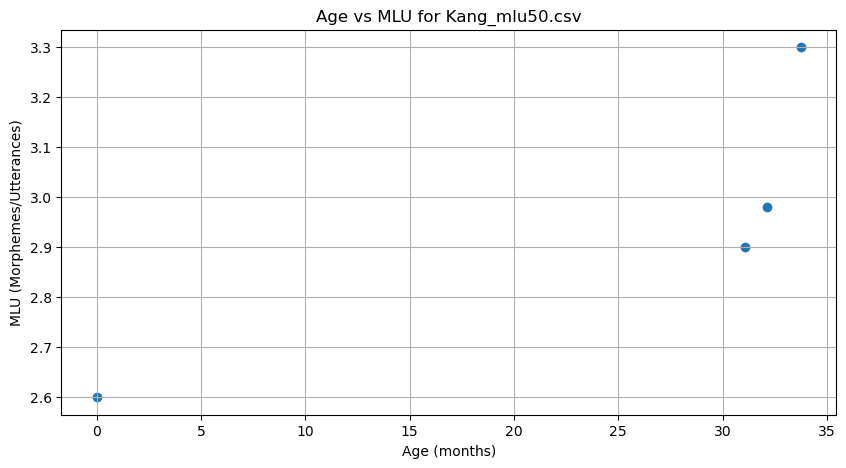

Spearman's rho for Kang_mlu50.csv: 1.0000

Chosen Transcripts for Kang_mlu50.csv: 
 ['01.ipcore.cex', '02.ipcore.cex', '19.ipcore.cex', '21.ipcore.cex'] 

MLU Scores for Kang_mlu50.csv: 
 [2.6, 2.9, 2.98, 3.3] 

Ages for Kang_mlu50.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666] 

Time Steps for Kang_mlu50.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329] 



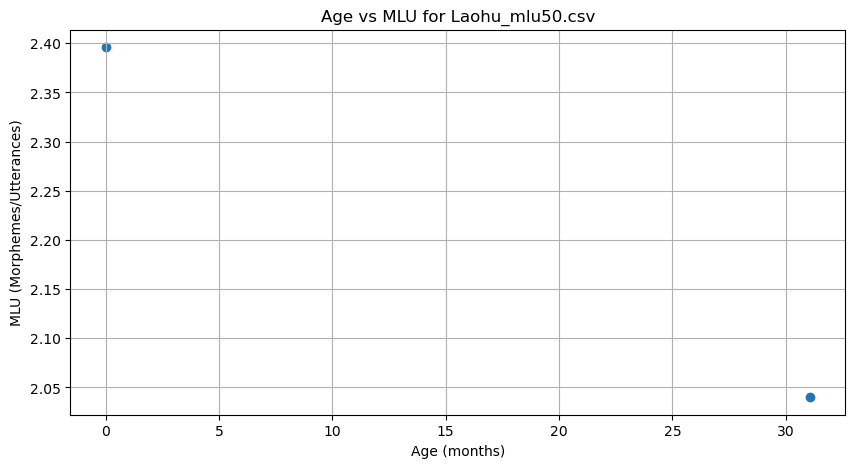

Spearman's rho for Laohu_mlu50.csv: -1.0000

Chosen Transcripts for Laohu_mlu50.csv: 
 ['01.ipcore.cex', '02.ipcore.cex'] 

MLU Scores for Laohu_mlu50.csv: 
 [2.396, 2.04] 

Ages for Laohu_mlu50.csv: 
 [0, 31.066666666666666] 

Time Steps for Laohu_mlu50.csv: 
 [31.066666666666666] 



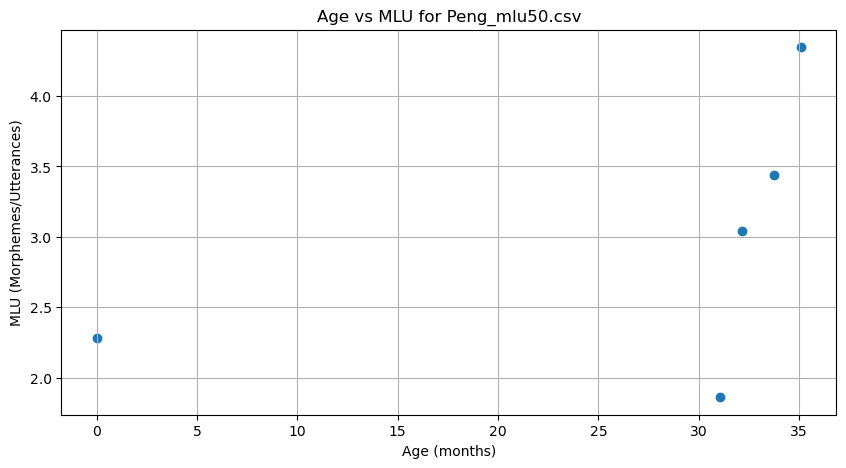

Spearman's rho for Peng_mlu50.csv: 0.9000

Chosen Transcripts for Peng_mlu50.csv: 
 ['01.ipcore.cex', '02.ipcore.cex', '19.ipcore.cex', '21.ipcore.cex', '24.ipcore.cex'] 

MLU Scores for Peng_mlu50.csv: 
 [2.28, 1.86, 3.04, 3.44, 4.347] 

Ages for Peng_mlu50.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666, 35.1] 

Time Steps for Peng_mlu50.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329, 1.3333333333333357] 



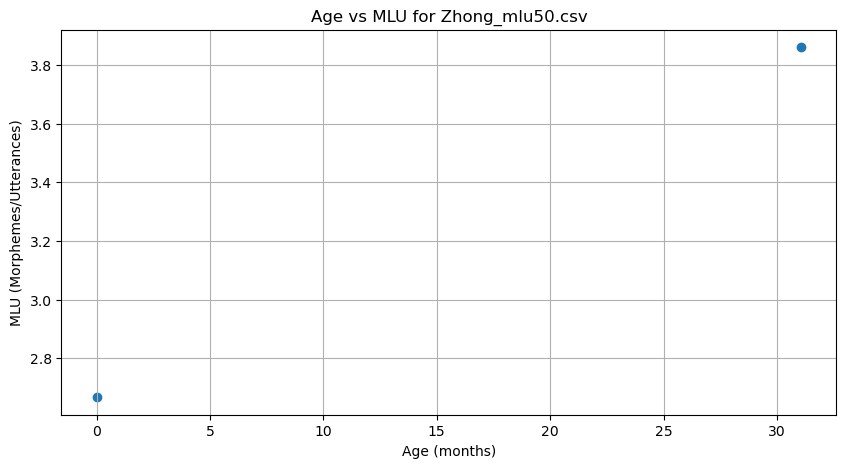

Spearman's rho for Zhong_mlu50.csv: 1.0000

Chosen Transcripts for Zhong_mlu50.csv: 
 ['01.ipcore.cex', '02.ipcore.cex'] 

MLU Scores for Zhong_mlu50.csv: 
 [2.667, 3.86] 

Ages for Zhong_mlu50.csv: 
 [0, 31.066666666666666] 

Time Steps for Zhong_mlu50.csv: 
 [31.066666666666666] 



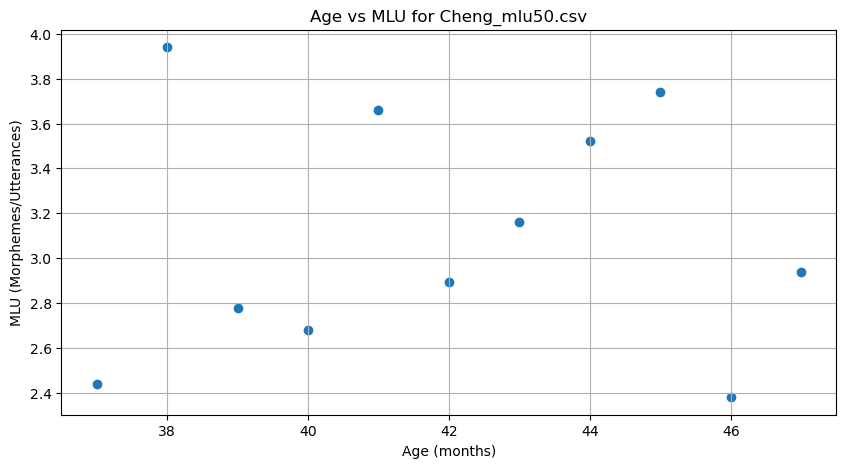

Spearman's rho for Cheng_mlu50.csv: 0.0545

Chosen Transcripts for Cheng_mlu50.csv: 
 ['030100.ipcore.cex', '030200.ipcore.cex', '030300.ipcore.cex', '030400.ipcore.cex', '030500.ipcore.cex', '030600.ipcore.cex', '030700.ipcore.cex', '030800.ipcore.cex', '030900.ipcore.cex', '031000.ipcore.cex', '031100.ipcore.cex'] 

MLU Scores for Cheng_mlu50.csv: 
 [2.44, 3.94, 2.776, 2.68, 3.66, 2.894, 3.16, 3.52, 3.74, 2.38, 2.94] 

Ages for Cheng_mlu50.csv: 
 [37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0] 

Time Steps for Cheng_mlu50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



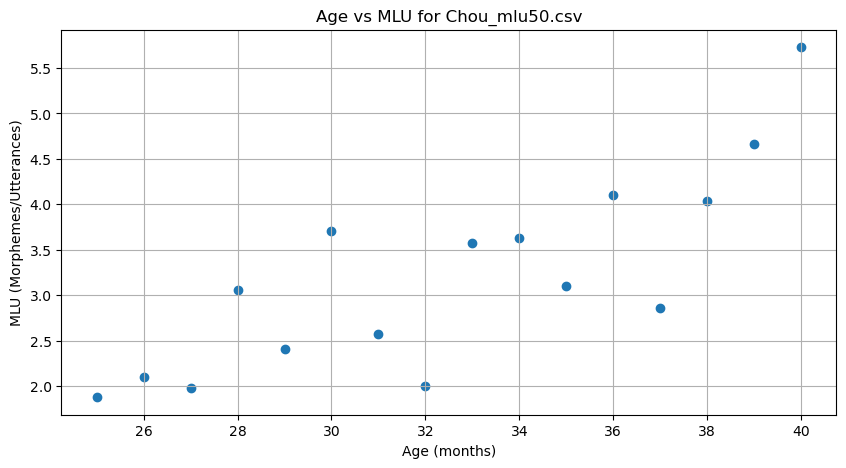

Spearman's rho for Chou_mlu50.csv: 0.8088

Chosen Transcripts for Chou_mlu50.csv: 
 ['020100.ipcore.cex', '020200.ipcore.cex', '020300.ipcore.cex', '020400.ipcore.cex', '020500.ipcore.cex', '020600.ipcore.cex', '020700.ipcore.cex', '020800.ipcore.cex', '020900.ipcore.cex', '021000.ipcore.cex', '021100.ipcore.cex', '030000.ipcore.cex', '030100.ipcore.cex', '030200.ipcore.cex', '030300.ipcore.cex', '030400.ipcore.cex'] 

MLU Scores for Chou_mlu50.csv: 
 [1.878, 2.106, 1.98, 3.063, 2.413, 3.708, 2.574, 2.0, 3.58, 3.63, 3.106, 4.104, 2.86, 4.04, 4.66, 5.729] 

Ages for Chou_mlu50.csv: 
 [25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Chou_mlu50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



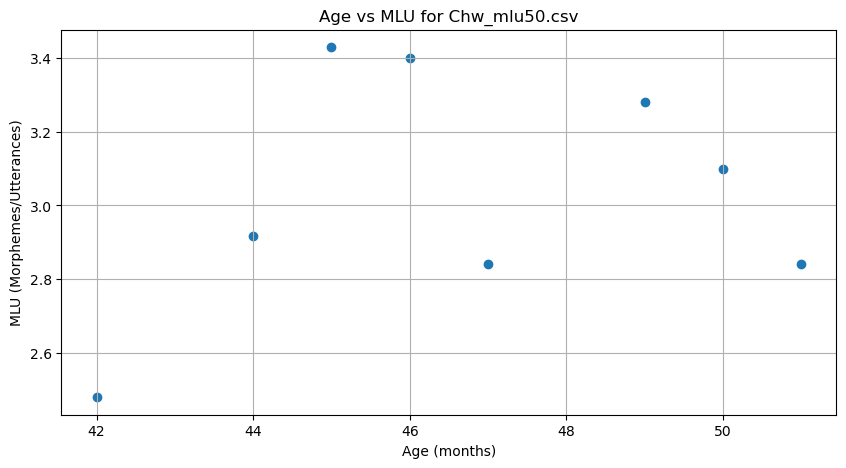

Spearman's rho for Chw_mlu50.csv: 0.0599

Chosen Transcripts for Chw_mlu50.csv: 
 ['030600.ipcore.cex', '030800.ipcore.cex', '030900.ipcore.cex', '031000.ipcore.cex', '031100.ipcore.cex', '040100.ipcore.cex', '040200.ipcore.cex', '040300.ipcore.cex'] 

MLU Scores for Chw_mlu50.csv: 
 [2.48, 2.918, 3.429, 3.4, 2.84, 3.28, 3.1, 2.84] 

Ages for Chw_mlu50.csv: 
 [42.0, 44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 51.0] 

Time Steps for Chw_mlu50.csv: 
 [2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0] 



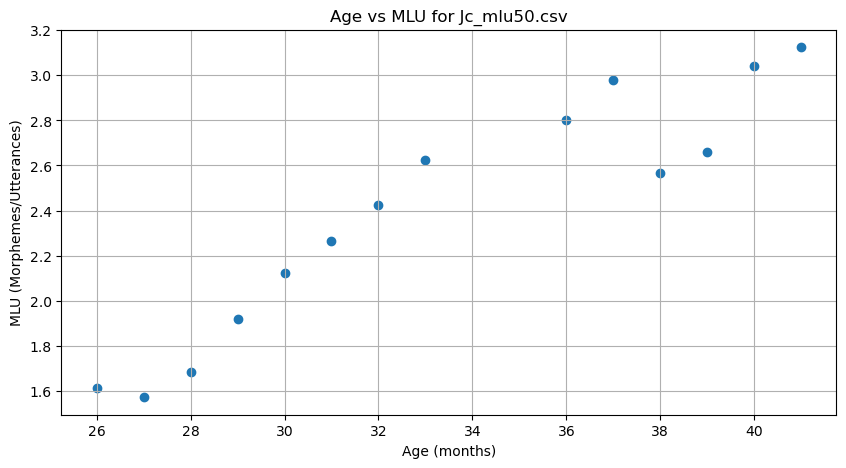

Spearman's rho for Jc_mlu50.csv: 0.9473

Chosen Transcripts for Jc_mlu50.csv: 
 ['020200.ipcore.cex', '020300.ipcore.cex', '020400.ipcore.cex', '020500.ipcore.cex', '020600.ipcore.cex', '020700.ipcore.cex', '020800.ipcore.cex', '020900.ipcore.cex', '030000.ipcore.cex', '030100.ipcore.cex', '030200.ipcore.cex', '030300.ipcore.cex', '030400.ipcore.cex', '030500.ipcore.cex'] 

MLU Scores for Jc_mlu50.csv: 
 [1.612, 1.571, 1.681, 1.917, 2.122, 2.265, 2.426, 2.625, 2.8, 2.98, 2.565, 2.66, 3.04, 3.125] 

Ages for Jc_mlu50.csv: 
 [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0] 

Time Steps for Jc_mlu50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



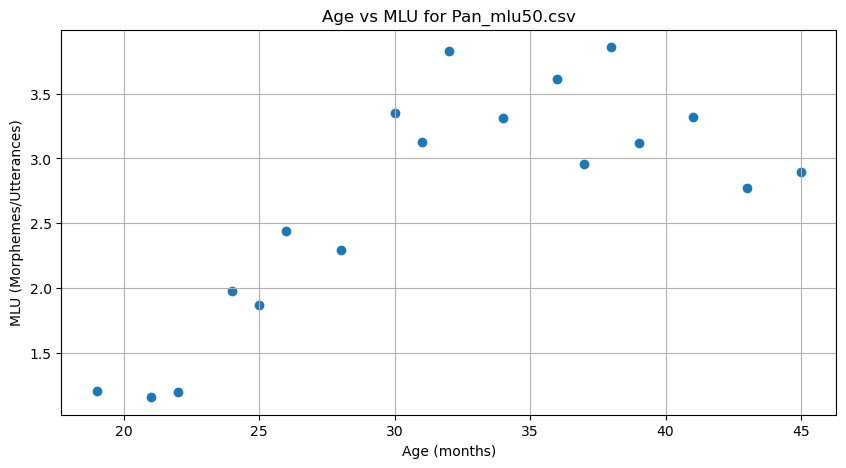

Spearman's rho for Pan_mlu50.csv: 0.6450

Chosen Transcripts for Pan_mlu50.csv: 
 ['010700.ipcore.cex', '010900.ipcore.cex', '011000.ipcore.cex', '020000.ipcore.cex', '020100.ipcore.cex', '020200.ipcore.cex', '020400.ipcore.cex', '020600.ipcore.cex', '020700.ipcore.cex', '020800.ipcore.cex', '021000.ipcore.cex', '030000.ipcore.cex', '030100.ipcore.cex', '030200.ipcore.cex', '030300.ipcore.cex', '030500.ipcore.cex', '030700.ipcore.cex', '030900.ipcore.cex'] 

MLU Scores for Pan_mlu50.csv: 
 [1.209, 1.16, 1.204, 1.979, 1.872, 2.444, 2.298, 3.347, 3.125, 3.826, 3.31, 3.609, 2.958, 3.857, 3.122, 3.319, 2.776, 2.896] 

Ages for Pan_mlu50.csv: 
 [19.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 45.0] 

Time Steps for Pan_mlu50.csv: 
 [2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0] 



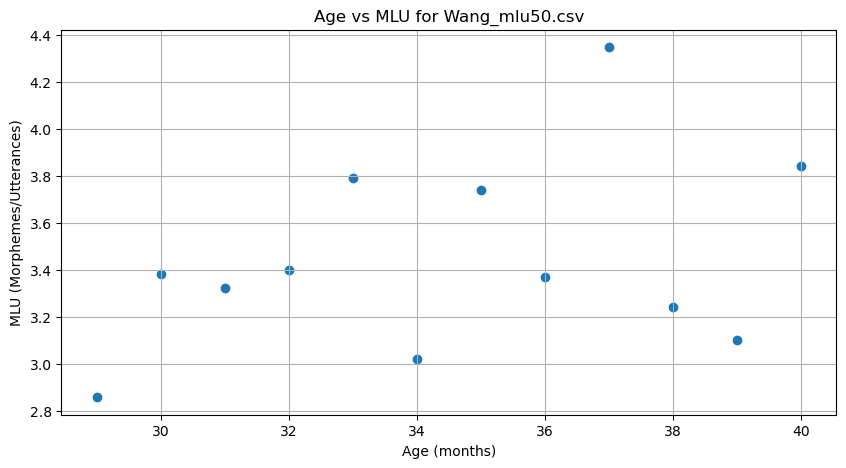

Spearman's rho for Wang_mlu50.csv: 0.2867

Chosen Transcripts for Wang_mlu50.csv: 
 ['020500.ipcore.cex', '020600.ipcore.cex', '020700.ipcore.cex', '020800.ipcore.cex', '020900.ipcore.cex', '021000.ipcore.cex', '021100.ipcore.cex', '030000.ipcore.cex', '030100.ipcore.cex', '030200.ipcore.cex', '030300.ipcore.cex', '030400.ipcore.cex'] 

MLU Scores for Wang_mlu50.csv: 
 [2.857, 3.38, 3.32, 3.4, 3.792, 3.02, 3.74, 3.367, 4.347, 3.24, 3.102, 3.84] 

Ages for Wang_mlu50.csv: 
 [29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Wang_mlu50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



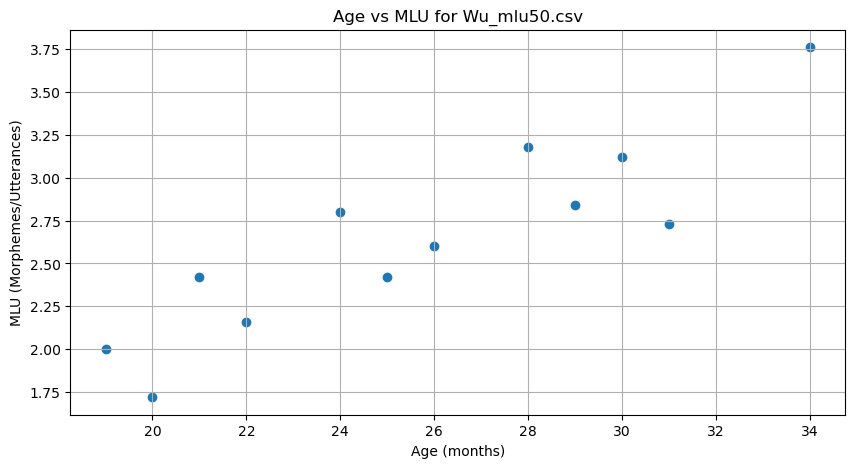

Spearman's rho for Wu_mlu50.csv: 0.8511

Chosen Transcripts for Wu_mlu50.csv: 
 ['010700.ipcore.cex', '010800.ipcore.cex', '010900.ipcore.cex', '011000.ipcore.cex', '020000.ipcore.cex', '020100.ipcore.cex', '020200.ipcore.cex', '020400.ipcore.cex', '020500.ipcore.cex', '020600.ipcore.cex', '020700.ipcore.cex', '021000.ipcore.cex'] 

MLU Scores for Wu_mlu50.csv: 
 [2.0, 1.72, 2.42, 2.16, 2.8, 2.42, 2.6, 3.18, 2.84, 3.122, 2.729, 3.76] 

Ages for Wu_mlu50.csv: 
 [19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 29.0, 30.0, 31.0, 34.0] 

Time Steps for Wu_mlu50.csv: 
 [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0] 



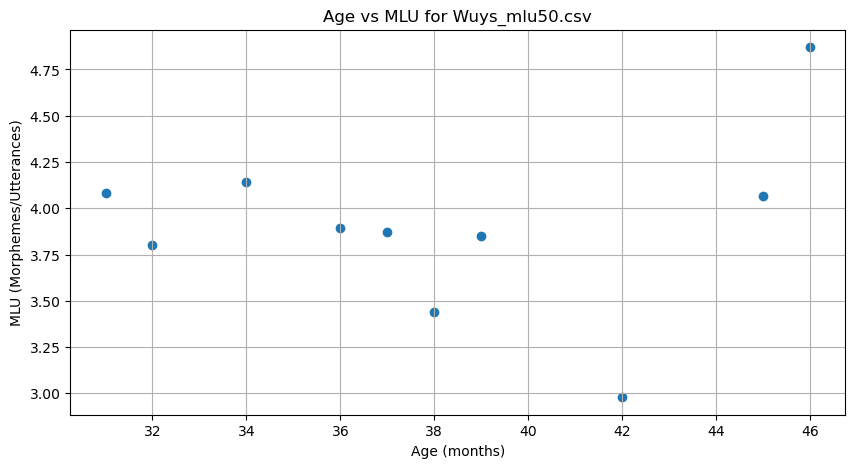

Spearman's rho for Wuys_mlu50.csv: -0.0182

Chosen Transcripts for Wuys_mlu50.csv: 
 ['020700.ipcore.cex', '020800.ipcore.cex', '021000.ipcore.cex', '030000.ipcore.cex', '030100.ipcore.cex', '030200.ipcore.cex', '030300.ipcore.cex', '030600.ipcore.cex', '030900.ipcore.cex', '031000.ipcore.cex'] 

MLU Scores for Wuys_mlu50.csv: 
 [4.083, 3.8, 4.14, 3.894, 3.872, 3.438, 3.848, 2.979, 4.065, 4.87] 

Ages for Wuys_mlu50.csv: 
 [31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 45.0, 46.0] 

Time Steps for Wuys_mlu50.csv: 
 [1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0] 



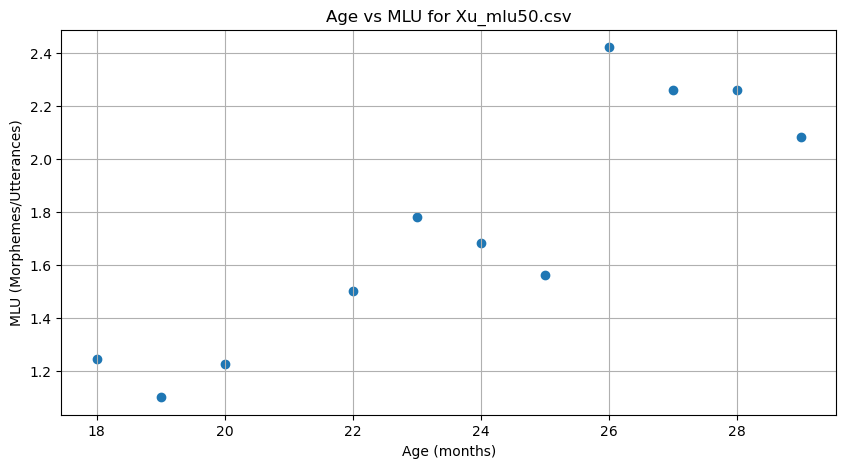

Spearman's rho for Xu_mlu50.csv: 0.8519

Chosen Transcripts for Xu_mlu50.csv: 
 ['010600.ipcore.cex', '010700.ipcore.cex', '010800.ipcore.cex', '011000.ipcore.cex', '011100.ipcore.cex', '020000.ipcore.cex', '020100.ipcore.cex', '020200.ipcore.cex', '020300.ipcore.cex', '020400.ipcore.cex', '020500.ipcore.cex'] 

MLU Scores for Xu_mlu50.csv: 
 [1.245, 1.1, 1.224, 1.5, 1.78, 1.68, 1.56, 2.42, 2.26, 2.26, 2.08] 

Ages for Xu_mlu50.csv: 
 [18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0] 

Time Steps for Xu_mlu50.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



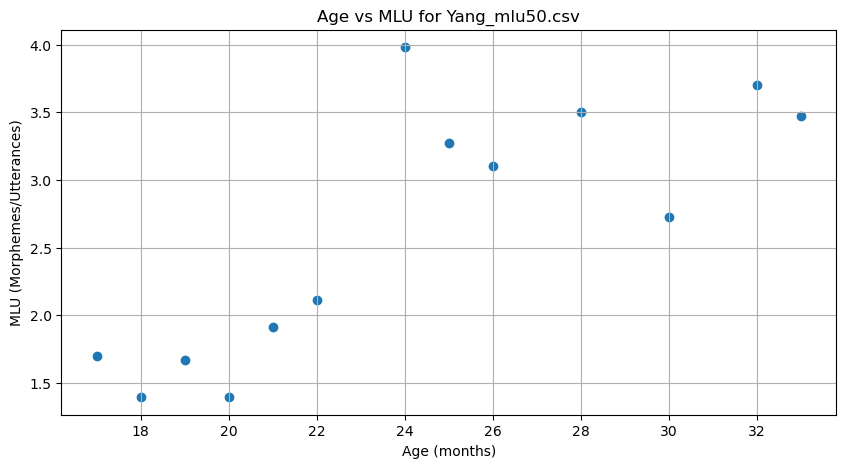

Spearman's rho for Yang_mlu50.csv: 0.7747

Chosen Transcripts for Yang_mlu50.csv: 
 ['010500.ipcore.cex', '010600.ipcore.cex', '010700.ipcore.cex', '010800.ipcore.cex', '010900.ipcore.cex', '011000.ipcore.cex', '020000.ipcore.cex', '020100.ipcore.cex', '020200.ipcore.cex', '020400.ipcore.cex', '020600.ipcore.cex', '020800.ipcore.cex', '020900.ipcore.cex'] 

MLU Scores for Yang_mlu50.csv: 
 [1.702, 1.396, 1.673, 1.395, 1.917, 2.111, 3.98, 3.271, 3.1, 3.5, 2.729, 3.702, 3.469] 

Ages for Yang_mlu50.csv: 
 [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 32.0, 33.0] 

Time Steps for Yang_mlu50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0] 



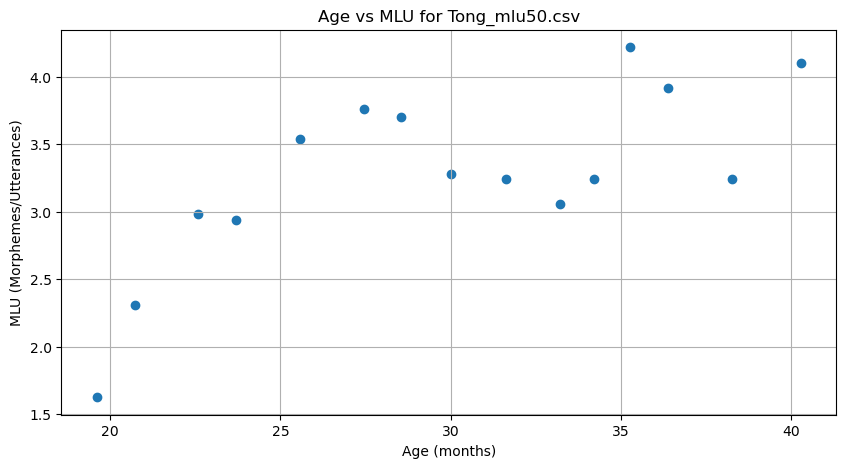

Spearman's rho for Tong_mlu50.csv: 0.6667

Chosen Transcripts for Tong_mlu50.csv: 
 ['010718.ipcore.cex', '010822.ipcore.cex', '011017.ipcore.cex', '011121.ipcore.cex', '020117.ipcore.cex', '020314.ipcore.cex', '020416.ipcore.cex', '020530.ipcore.cex', '020719.ipcore.cex', '020906.ipcore.cex', '021006.ipcore.cex', '021108.ipcore.cex', '030012.ipcore.cex', '030208.ipcore.cex', '030409.ipcore.cex'] 

MLU Scores for Tong_mlu50.csv: 
 [1.625, 2.306, 2.98, 2.938, 3.54, 3.76, 3.7, 3.28, 3.24, 3.06, 3.245, 4.22, 3.92, 3.24, 4.1] 

Ages for Tong_mlu50.csv: 
 [19.6, 20.733333333333334, 22.566666666666666, 23.7, 25.566666666666666, 27.46666666666667, 28.53333333333333, 30.0, 31.633333333333333, 33.2, 34.2, 35.266666666666666, 36.4, 38.266666666666666, 40.3] 

Time Steps for Tong_mlu50.csv: 
 [1.1333333333333329, 1.8333333333333321, 1.1333333333333329, 1.8666666666666671, 1.9000000000000021, 1.0666666666666629, 1.4666666666666686, 1.6333333333333329, 1.56666666666667, 1.0, 1.0666666666666629, 1.1

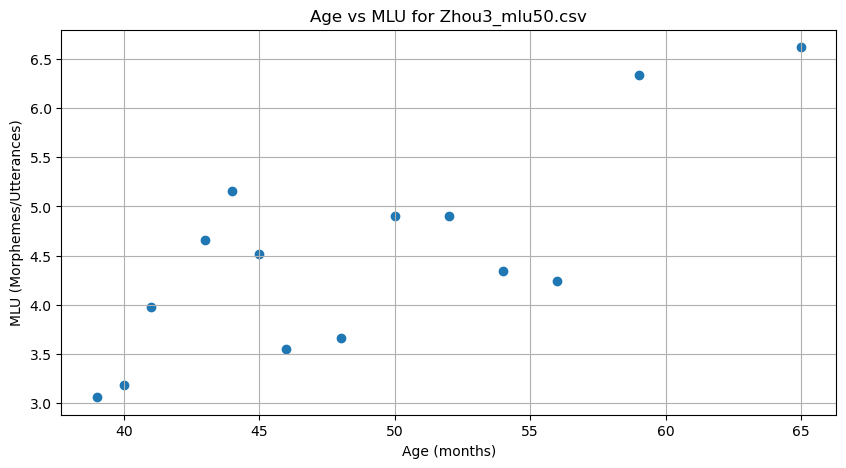

Spearman's rho for Zhou3_mlu50.csv: 0.6293

Chosen Transcripts for Zhou3_mlu50.csv: 
 ['000108.ipcore.cex', '000227.ipcore.cex', '000326.ipcore.cex', '000506.ipcore.cex', '000610.ipcore.cex', '000702.ipcore.cex', '000822.ipcore.cex', '001005.ipcore.cex', '001209.ipcore.cex', '010218.ipcore.cex', '010421.ipcore.cex', '010630.ipcore.cex', '010908.ipcore.cex', '020323.ipcore.cex'] 

MLU Scores for Zhou3_mlu50.csv: 
 [3.06, 3.18, 3.98, 4.66, 5.16, 4.52, 3.551, 3.66, 4.9, 4.9, 4.34, 4.24, 6.34, 6.62] 

Ages for Zhou3_mlu50.csv: 
 [39.0, 40.0, 41.0, 43.0, 44.0, 45.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 59.0, 65.0] 

Time Steps for Zhou3_mlu50.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 6.0] 



In [10]:
age_mlu_plots(mlu_files_50, spearman_rhos_50, age_files)

## Age vs MLU (100 Utterances)

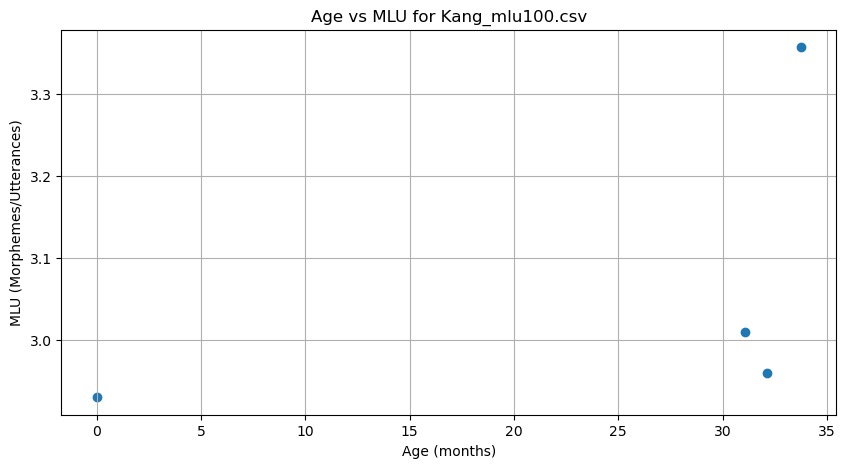

Spearman's rho for Kang_mlu100.csv: 0.8000

Chosen Transcripts for Kang_mlu100.csv: 
 ['01.ipcore-100.cex', '02.ipcore-100.cex', '19.ipcore-100.cex', '21.ipcore-100.cex'] 

MLU Scores for Kang_mlu100.csv: 
 [2.93, 3.01, 2.96, 3.357] 

Ages for Kang_mlu100.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666] 

Time Steps for Kang_mlu100.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329] 



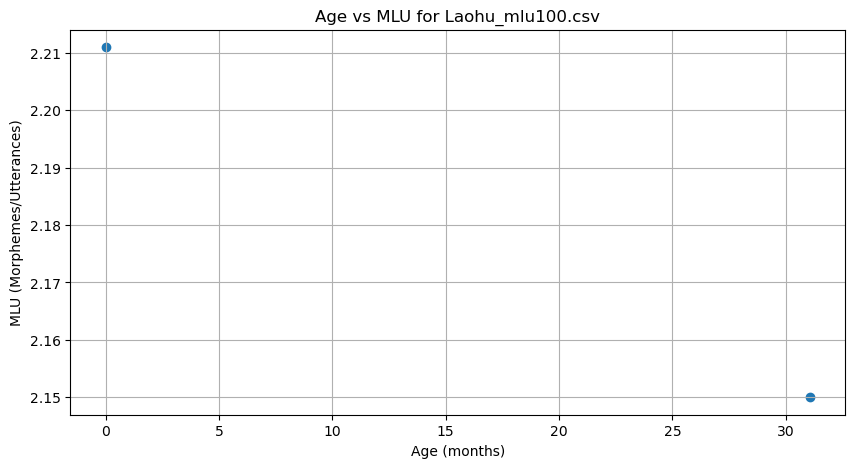

Spearman's rho for Laohu_mlu100.csv: -1.0000

Chosen Transcripts for Laohu_mlu100.csv: 
 ['01.ipcore-100.cex', '02.ipcore-100.cex'] 

MLU Scores for Laohu_mlu100.csv: 
 [2.211, 2.15] 

Ages for Laohu_mlu100.csv: 
 [0, 31.066666666666666] 

Time Steps for Laohu_mlu100.csv: 
 [31.066666666666666] 



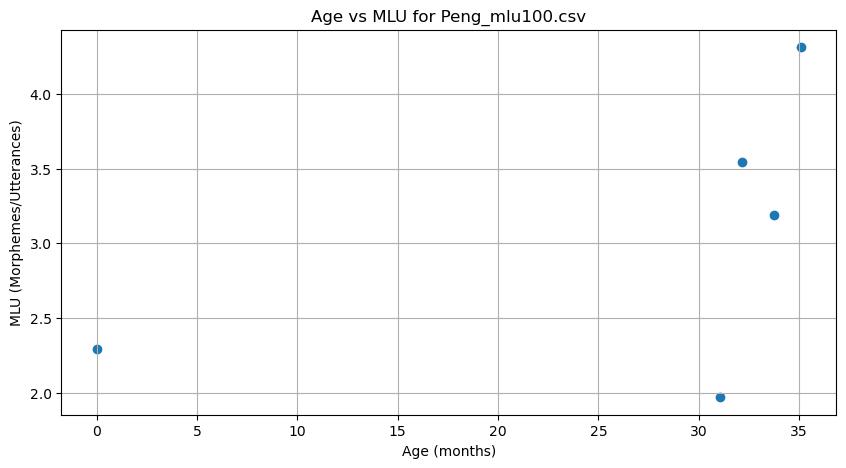

Spearman's rho for Peng_mlu100.csv: 0.8000

Chosen Transcripts for Peng_mlu100.csv: 
 ['01.ipcore-100.cex', '02.ipcore-100.cex', '19.ipcore-100.cex', '21.ipcore-100.cex', '24.ipcore-100.cex'] 

MLU Scores for Peng_mlu100.csv: 
 [2.295, 1.97, 3.545, 3.192, 4.313] 

Ages for Peng_mlu100.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666, 35.1] 

Time Steps for Peng_mlu100.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329, 1.3333333333333357] 



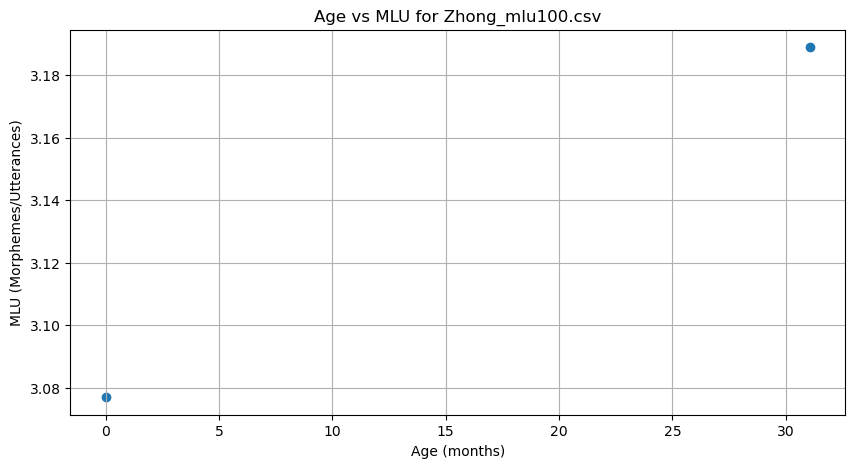

Spearman's rho for Zhong_mlu100.csv: 1.0000

Chosen Transcripts for Zhong_mlu100.csv: 
 ['01.ipcore-100.cex', '02.ipcore-100.cex'] 

MLU Scores for Zhong_mlu100.csv: 
 [3.077, 3.189] 

Ages for Zhong_mlu100.csv: 
 [0, 31.066666666666666] 

Time Steps for Zhong_mlu100.csv: 
 [31.066666666666666] 



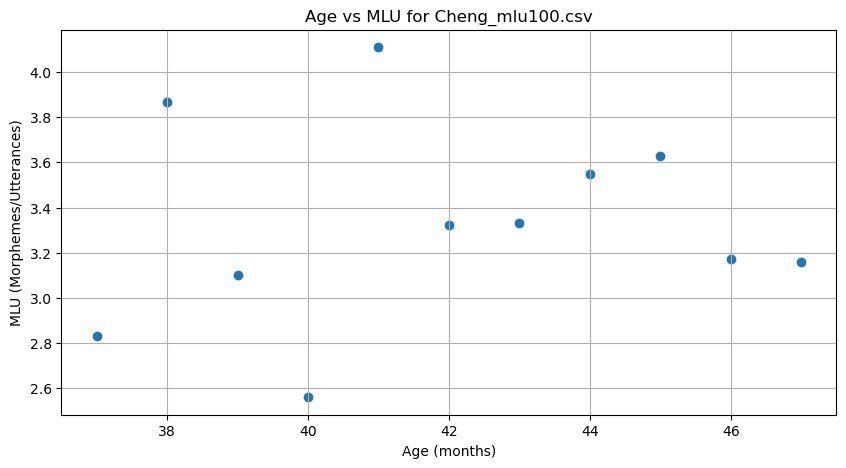

Spearman's rho for Cheng_mlu100.csv: 0.1636

Chosen Transcripts for Cheng_mlu100.csv: 
 ['030100.ipcore-100.cex', '030200.ipcore-100.cex', '030300.ipcore-100.cex', '030400.ipcore-100.cex', '030500.ipcore-100.cex', '030600.ipcore-100.cex', '030700.ipcore-100.cex', '030800.ipcore-100.cex', '030900.ipcore-100.cex', '031000.ipcore-100.cex', '031100.ipcore-100.cex'] 

MLU Scores for Cheng_mlu100.csv: 
 [2.83, 3.867, 3.102, 2.56, 4.11, 3.323, 3.33, 3.55, 3.63, 3.17, 3.16] 

Ages for Cheng_mlu100.csv: 
 [37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0] 

Time Steps for Cheng_mlu100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



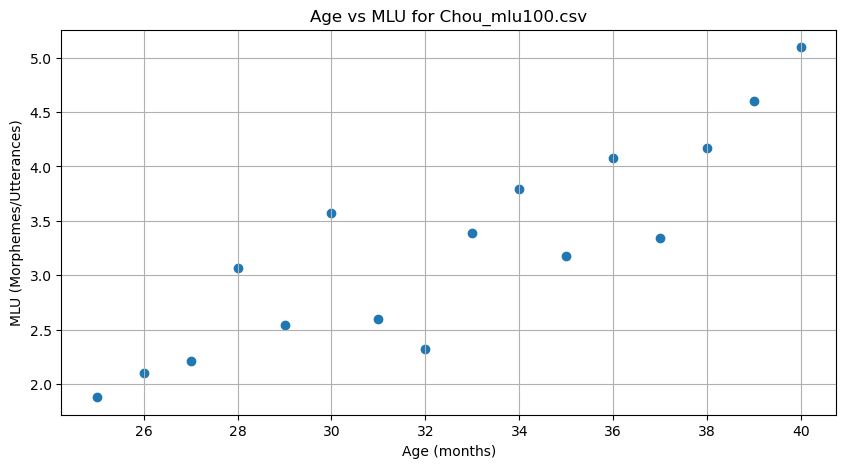

Spearman's rho for Chou_mlu100.csv: 0.8794

Chosen Transcripts for Chou_mlu100.csv: 
 ['020100.ipcore-100.cex', '020200.ipcore-100.cex', '020300.ipcore-100.cex', '020400.ipcore-100.cex', '020500.ipcore-100.cex', '020600.ipcore-100.cex', '020700.ipcore-100.cex', '020800.ipcore-100.cex', '020900.ipcore-100.cex', '021000.ipcore-100.cex', '021100.ipcore-100.cex', '030000.ipcore-100.cex', '030100.ipcore-100.cex', '030200.ipcore-100.cex', '030300.ipcore-100.cex', '030400.ipcore-100.cex'] 

MLU Scores for Chou_mlu100.csv: 
 [1.878, 2.105, 2.214, 3.064, 2.543, 3.57, 2.594, 2.321, 3.384, 3.793, 3.175, 4.082, 3.343, 4.17, 4.602, 5.096] 

Ages for Chou_mlu100.csv: 
 [25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Chou_mlu100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



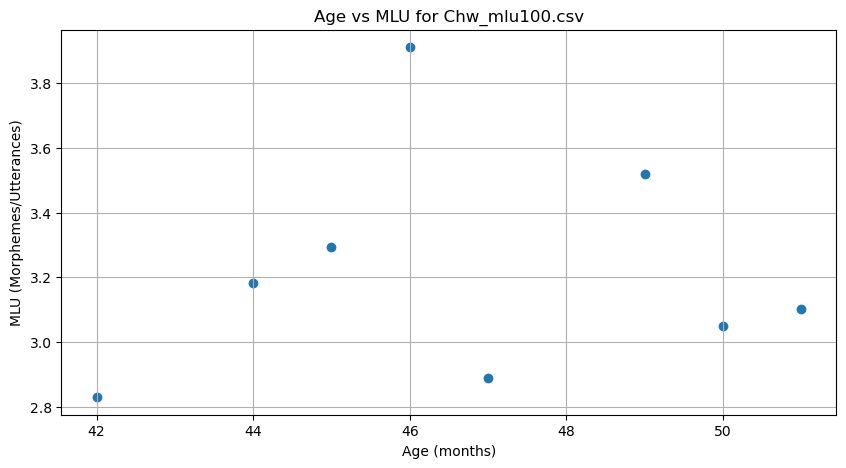

Spearman's rho for Chw_mlu100.csv: 0.0952

Chosen Transcripts for Chw_mlu100.csv: 
 ['030600.ipcore-100.cex', '030800.ipcore-100.cex', '030900.ipcore-100.cex', '031000.ipcore-100.cex', '031100.ipcore-100.cex', '040100.ipcore-100.cex', '040200.ipcore-100.cex', '040300.ipcore-100.cex'] 

MLU Scores for Chw_mlu100.csv: 
 [2.83, 3.182, 3.293, 3.91, 2.89, 3.52, 3.05, 3.101] 

Ages for Chw_mlu100.csv: 
 [42.0, 44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 51.0] 

Time Steps for Chw_mlu100.csv: 
 [2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0] 



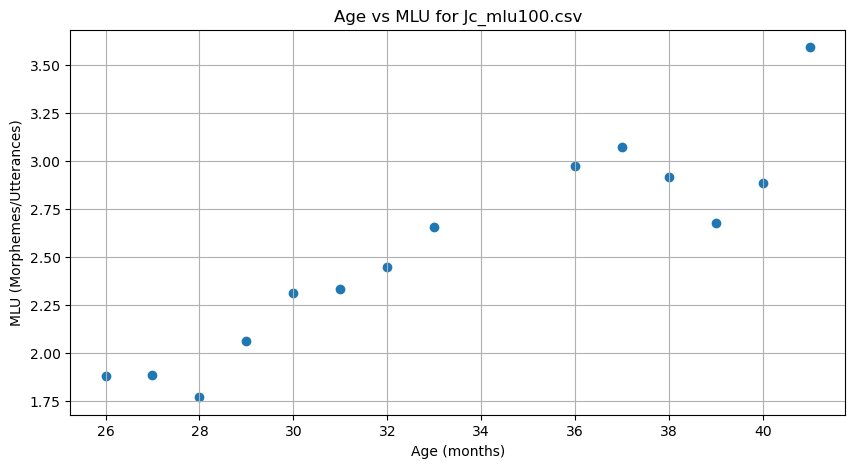

Spearman's rho for Jc_mlu100.csv: 0.9077

Chosen Transcripts for Jc_mlu100.csv: 
 ['020200.ipcore-100.cex', '020300.ipcore-100.cex', '020400.ipcore-100.cex', '020500.ipcore-100.cex', '020600.ipcore-100.cex', '020700.ipcore-100.cex', '020800.ipcore-100.cex', '020900.ipcore-100.cex', '030000.ipcore-100.cex', '030100.ipcore-100.cex', '030200.ipcore-100.cex', '030300.ipcore-100.cex', '030400.ipcore-100.cex', '030500.ipcore-100.cex'] 

MLU Scores for Jc_mlu100.csv: 
 [1.879, 1.887, 1.771, 2.063, 2.313, 2.337, 2.447, 2.66, 2.975, 3.075, 2.916, 2.677, 2.887, 3.594] 

Ages for Jc_mlu100.csv: 
 [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0] 

Time Steps for Jc_mlu100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



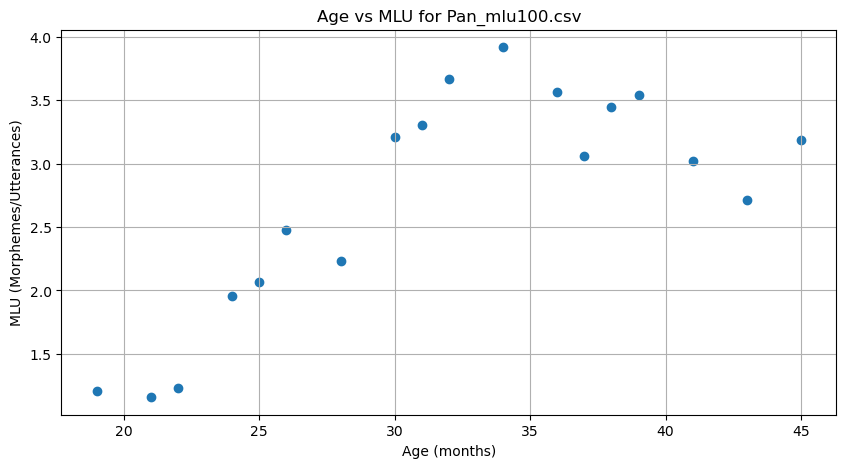

Spearman's rho for Pan_mlu100.csv: 0.6512

Chosen Transcripts for Pan_mlu100.csv: 
 ['010700.ipcore-100.cex', '010900.ipcore-100.cex', '011000.ipcore-100.cex', '020000.ipcore-100.cex', '020100.ipcore-100.cex', '020200.ipcore-100.cex', '020400.ipcore-100.cex', '020600.ipcore-100.cex', '020700.ipcore-100.cex', '020800.ipcore-100.cex', '021000.ipcore-100.cex', '030000.ipcore-100.cex', '030100.ipcore-100.cex', '030200.ipcore-100.cex', '030300.ipcore-100.cex', '030500.ipcore-100.cex', '030700.ipcore-100.cex', '030900.ipcore-100.cex'] 

MLU Scores for Pan_mlu100.csv: 
 [1.209, 1.158, 1.229, 1.956, 2.063, 2.477, 2.232, 3.212, 3.307, 3.667, 3.918, 3.565, 3.063, 3.443, 3.545, 3.021, 2.714, 3.183] 

Ages for Pan_mlu100.csv: 
 [19.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 45.0] 

Time Steps for Pan_mlu100.csv: 
 [2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0] 



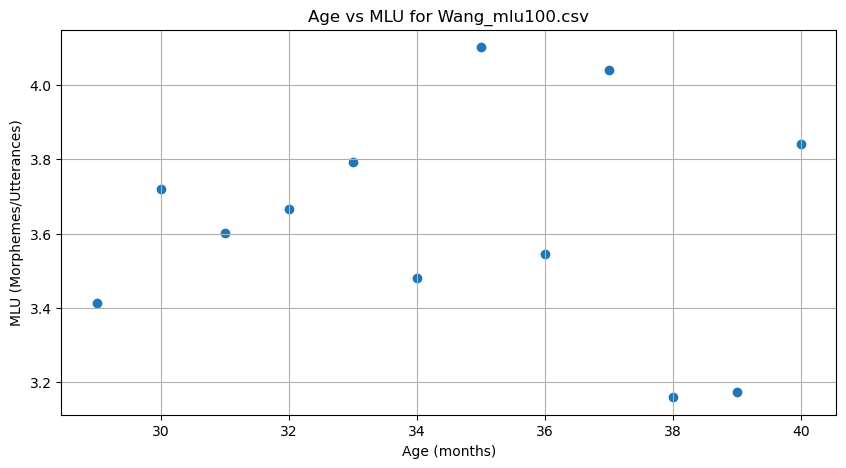

Spearman's rho for Wang_mlu100.csv: 0.0140

Chosen Transcripts for Wang_mlu100.csv: 
 ['020500.ipcore-100.cex', '020600.ipcore-100.cex', '020700.ipcore-100.cex', '020800.ipcore-100.cex', '020900.ipcore-100.cex', '021000.ipcore-100.cex', '021100.ipcore-100.cex', '030000.ipcore-100.cex', '030100.ipcore-100.cex', '030200.ipcore-100.cex', '030300.ipcore-100.cex', '030400.ipcore-100.cex'] 

MLU Scores for Wang_mlu100.csv: 
 [3.414, 3.72, 3.602, 3.667, 3.792, 3.48, 4.101, 3.545, 4.041, 3.16, 3.173, 3.84] 

Ages for Wang_mlu100.csv: 
 [29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Wang_mlu100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



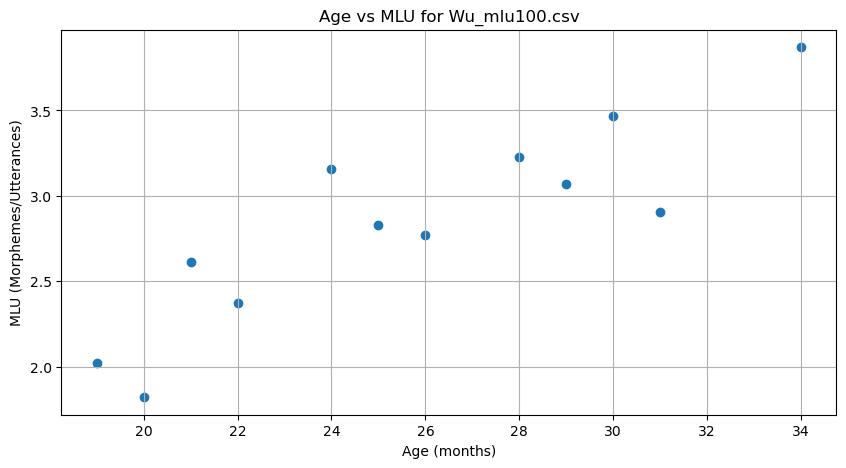

Spearman's rho for Wu_mlu100.csv: 0.8392

Chosen Transcripts for Wu_mlu100.csv: 
 ['010700.ipcore-100.cex', '010800.ipcore-100.cex', '010900.ipcore-100.cex', '011000.ipcore-100.cex', '020000.ipcore-100.cex', '020100.ipcore-100.cex', '020200.ipcore-100.cex', '020400.ipcore-100.cex', '020500.ipcore-100.cex', '020600.ipcore-100.cex', '020700.ipcore-100.cex', '021000.ipcore-100.cex'] 

MLU Scores for Wu_mlu100.csv: 
 [2.024, 1.821, 2.61, 2.37, 3.16, 2.83, 2.77, 3.23, 3.07, 3.465, 2.907, 3.87] 

Ages for Wu_mlu100.csv: 
 [19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 29.0, 30.0, 31.0, 34.0] 

Time Steps for Wu_mlu100.csv: 
 [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0] 



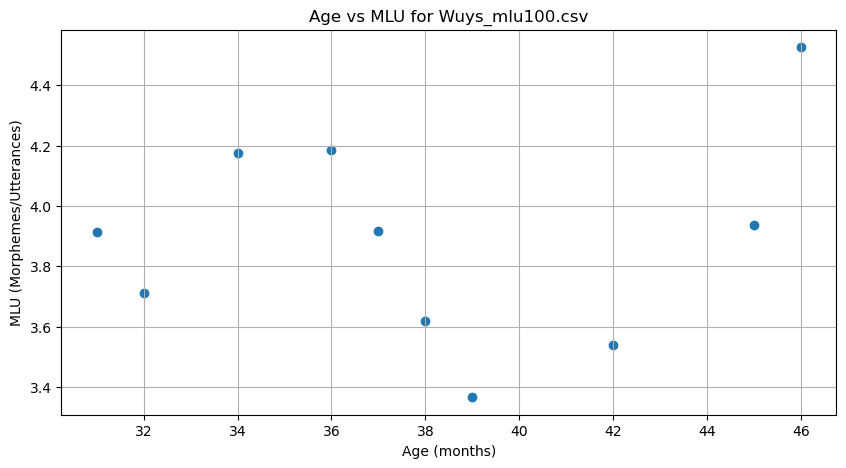

Spearman's rho for Wuys_mlu100.csv: 0.0545

Chosen Transcripts for Wuys_mlu100.csv: 
 ['020700.ipcore-100.cex', '020800.ipcore-100.cex', '021000.ipcore-100.cex', '030000.ipcore-100.cex', '030100.ipcore-100.cex', '030200.ipcore-100.cex', '030300.ipcore-100.cex', '030600.ipcore-100.cex', '030900.ipcore-100.cex', '031000.ipcore-100.cex'] 

MLU Scores for Wuys_mlu100.csv: 
 [3.914, 3.713, 4.176, 4.185, 3.917, 3.619, 3.366, 3.538, 3.936, 4.526] 

Ages for Wuys_mlu100.csv: 
 [31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 45.0, 46.0] 

Time Steps for Wuys_mlu100.csv: 
 [1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0] 



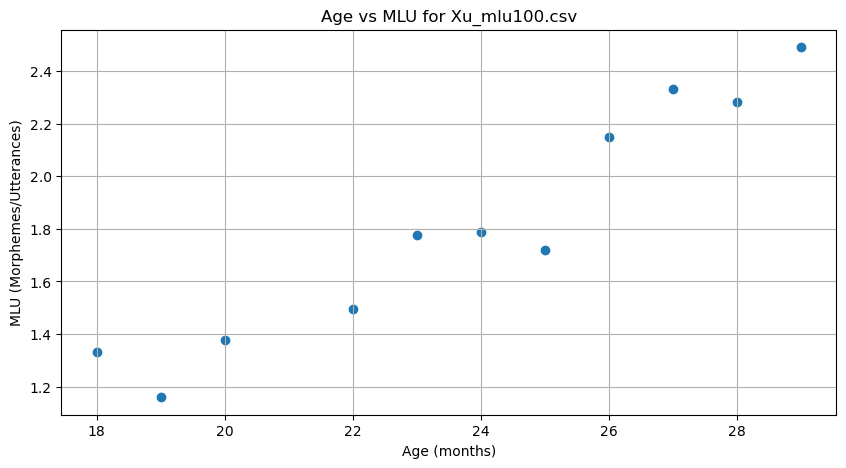

Spearman's rho for Xu_mlu100.csv: 0.9545

Chosen Transcripts for Xu_mlu100.csv: 
 ['010600.ipcore-100.cex', '010700.ipcore-100.cex', '010800.ipcore-100.cex', '011000.ipcore-100.cex', '011100.ipcore-100.cex', '020000.ipcore-100.cex', '020100.ipcore-100.cex', '020200.ipcore-100.cex', '020300.ipcore-100.cex', '020400.ipcore-100.cex', '020500.ipcore-100.cex'] 

MLU Scores for Xu_mlu100.csv: 
 [1.333, 1.16, 1.376, 1.495, 1.778, 1.788, 1.72, 2.15, 2.333, 2.28, 2.49] 

Ages for Xu_mlu100.csv: 
 [18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0] 

Time Steps for Xu_mlu100.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



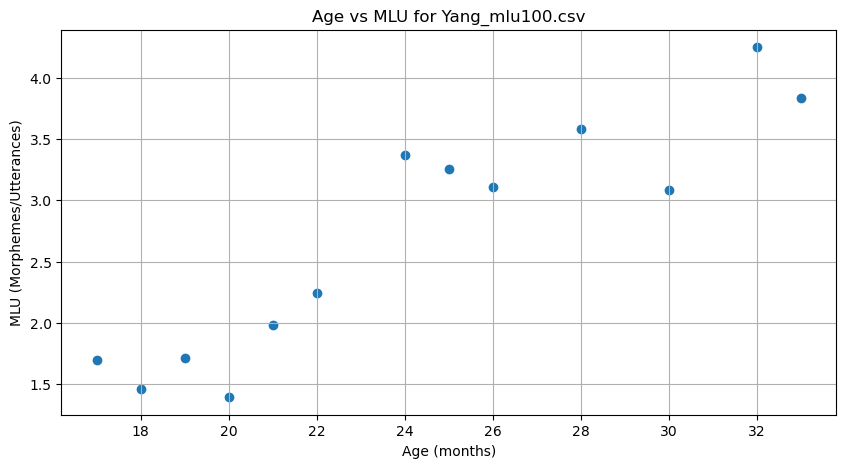

Spearman's rho for Yang_mlu100.csv: 0.8791

Chosen Transcripts for Yang_mlu100.csv: 
 ['010500.ipcore-100.cex', '010600.ipcore-100.cex', '010700.ipcore-100.cex', '010800.ipcore-100.cex', '010900.ipcore-100.cex', '011000.ipcore-100.cex', '020000.ipcore-100.cex', '020100.ipcore-100.cex', '020200.ipcore-100.cex', '020400.ipcore-100.cex', '020600.ipcore-100.cex', '020800.ipcore-100.cex', '020900.ipcore-100.cex'] 

MLU Scores for Yang_mlu100.csv: 
 [1.702, 1.458, 1.716, 1.395, 1.984, 2.241, 3.367, 3.253, 3.112, 3.584, 3.084, 4.247, 3.835] 

Ages for Yang_mlu100.csv: 
 [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 32.0, 33.0] 

Time Steps for Yang_mlu100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0] 



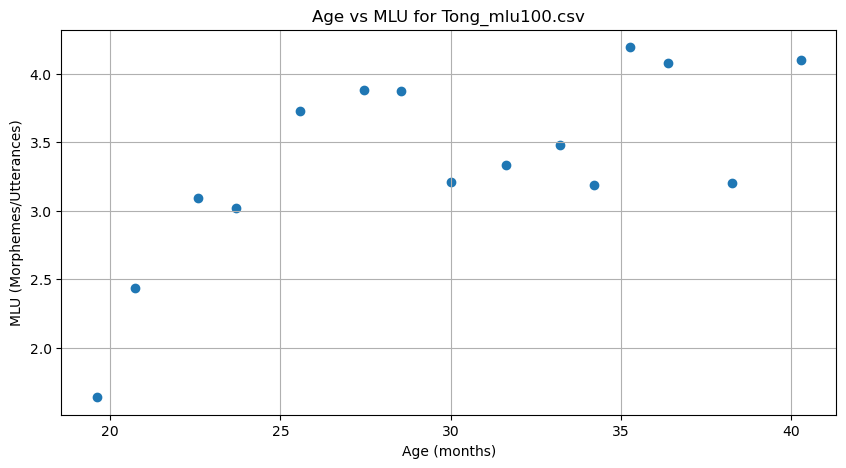

Spearman's rho for Tong_mlu100.csv: 0.6571

Chosen Transcripts for Tong_mlu100.csv: 
 ['010718.ipcore-100.cex', '010822.ipcore-100.cex', '011017.ipcore-100.cex', '011121.ipcore-100.cex', '020117.ipcore-100.cex', '020314.ipcore-100.cex', '020416.ipcore-100.cex', '020530.ipcore-100.cex', '020719.ipcore-100.cex', '020906.ipcore-100.cex', '021006.ipcore-100.cex', '021108.ipcore-100.cex', '030012.ipcore-100.cex', '030208.ipcore-100.cex', '030409.ipcore-100.cex'] 

MLU Scores for Tong_mlu100.csv: 
 [1.64, 2.433, 3.093, 3.02, 3.73, 3.88, 3.87, 3.212, 3.33, 3.48, 3.184, 4.192, 4.08, 3.2, 4.101] 

Ages for Tong_mlu100.csv: 
 [19.6, 20.733333333333334, 22.566666666666666, 23.7, 25.566666666666666, 27.46666666666667, 28.53333333333333, 30.0, 31.633333333333333, 33.2, 34.2, 35.266666666666666, 36.4, 38.266666666666666, 40.3] 

Time Steps for Tong_mlu100.csv: 
 [1.1333333333333329, 1.8333333333333321, 1.1333333333333329, 1.8666666666666671, 1.9000000000000021, 1.0666666666666629, 1.4666666666666686

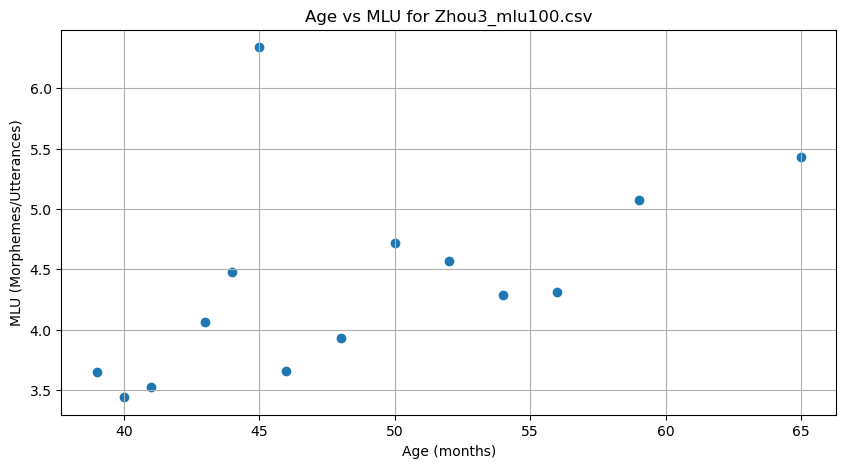

Spearman's rho for Zhou3_mlu100.csv: 0.6791

Chosen Transcripts for Zhou3_mlu100.csv: 
 ['000108.ipcore-100.cex', '000227.ipcore-100.cex', '000326.ipcore-100.cex', '000506.ipcore-100.cex', '000610.ipcore-100.cex', '000702.ipcore-100.cex', '000822.ipcore-100.cex', '001005.ipcore-100.cex', '001209.ipcore-100.cex', '010218.ipcore-100.cex', '010421.ipcore-100.cex', '010630.ipcore-100.cex', '010908.ipcore-100.cex', '020323.ipcore-100.cex'] 

MLU Scores for Zhou3_mlu100.csv: 
 [3.65, 3.439, 3.52, 4.06, 4.48, 6.34, 3.657, 3.93, 4.72, 4.57, 4.29, 4.31, 5.07, 5.43] 

Ages for Zhou3_mlu100.csv: 
 [39.0, 40.0, 41.0, 43.0, 44.0, 45.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 59.0, 65.0] 

Time Steps for Zhou3_mlu100.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 6.0] 



In [11]:
age_mlu_plots(mlu_files_100, spearman_rhos_100, age_files)

## Age vs MLU (All Utterances)

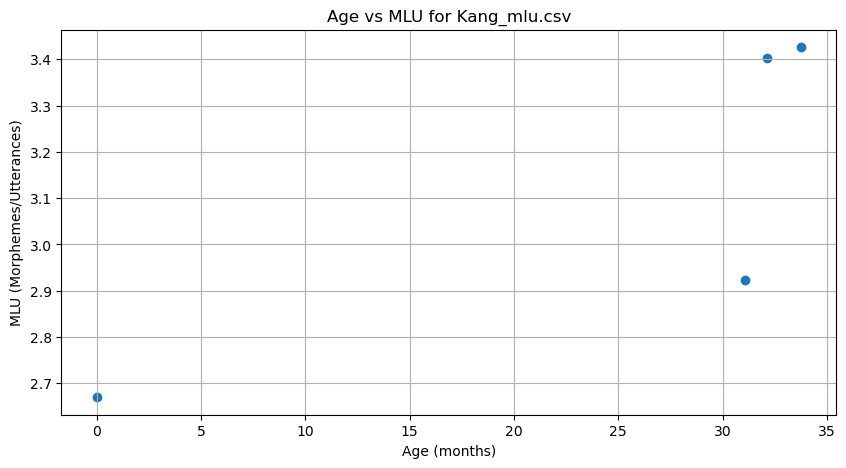

Spearman's rho for Kang_mlu.csv: 1.0000

Chosen Transcripts for Kang_mlu.csv: 
 ['01.cha', '02.cha', '19.cha', '21.cha'] 

MLU Scores for Kang_mlu.csv: 
 [2.67, 2.924, 3.402, 3.426] 

Ages for Kang_mlu.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666] 

Time Steps for Kang_mlu.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329] 



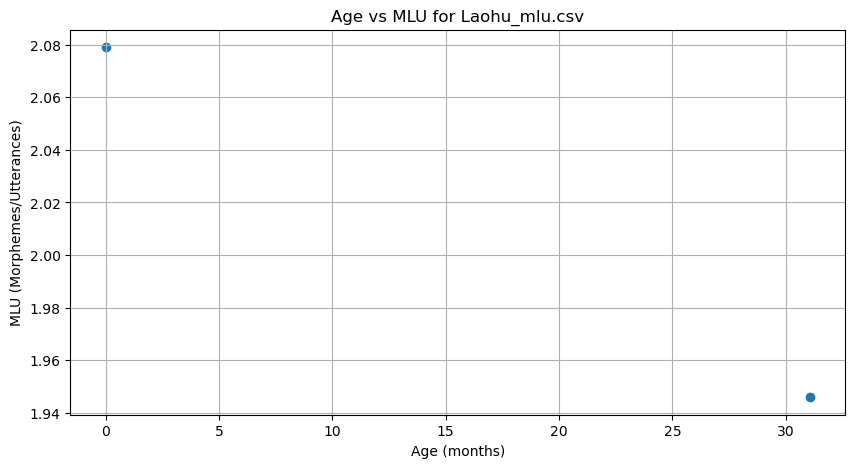

Spearman's rho for Laohu_mlu.csv: -1.0000

Chosen Transcripts for Laohu_mlu.csv: 
 ['01.cha', '02.cha'] 

MLU Scores for Laohu_mlu.csv: 
 [2.079, 1.946] 

Ages for Laohu_mlu.csv: 
 [0, 31.066666666666666] 

Time Steps for Laohu_mlu.csv: 
 [31.066666666666666] 



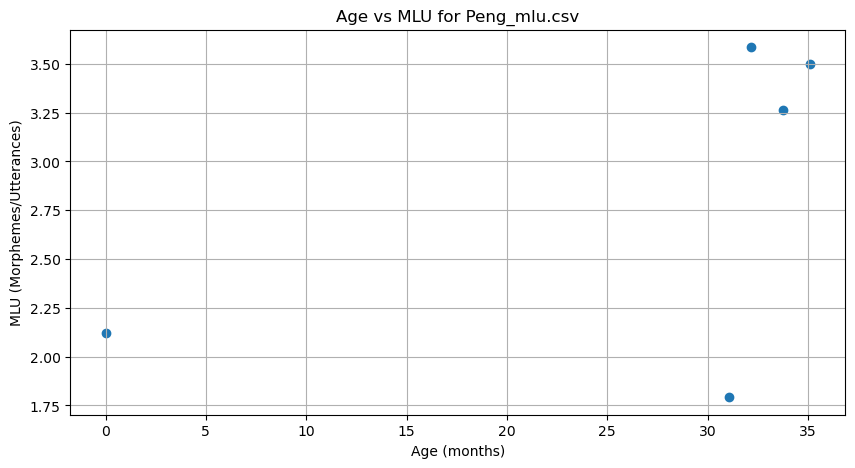

Spearman's rho for Peng_mlu.csv: 0.6000

Chosen Transcripts for Peng_mlu.csv: 
 ['01.cha', '02.cha', '19.cha', '21.cha', '24.cha'] 

MLU Scores for Peng_mlu.csv: 
 [2.119, 1.792, 3.585, 3.261, 3.498] 

Ages for Peng_mlu.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666, 35.1] 

Time Steps for Peng_mlu.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329, 1.3333333333333357] 



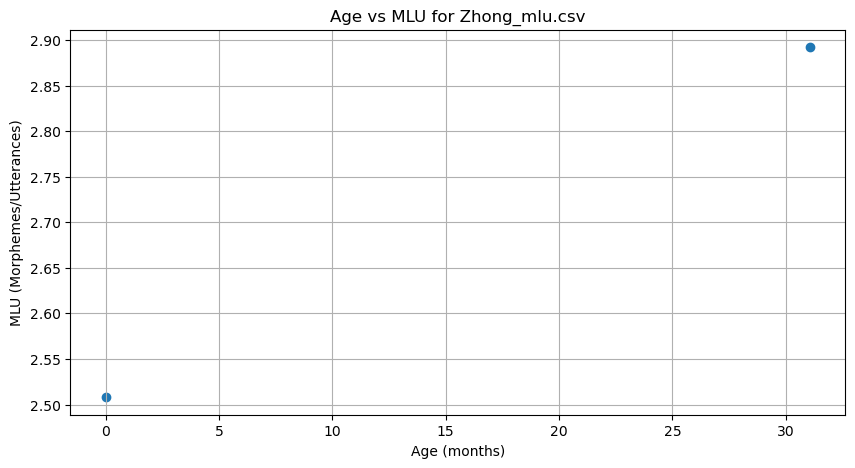

Spearman's rho for Zhong_mlu.csv: 1.0000

Chosen Transcripts for Zhong_mlu.csv: 
 ['01.cha', '02.cha'] 

MLU Scores for Zhong_mlu.csv: 
 [2.508, 2.892] 

Ages for Zhong_mlu.csv: 
 [0, 31.066666666666666] 

Time Steps for Zhong_mlu.csv: 
 [31.066666666666666] 



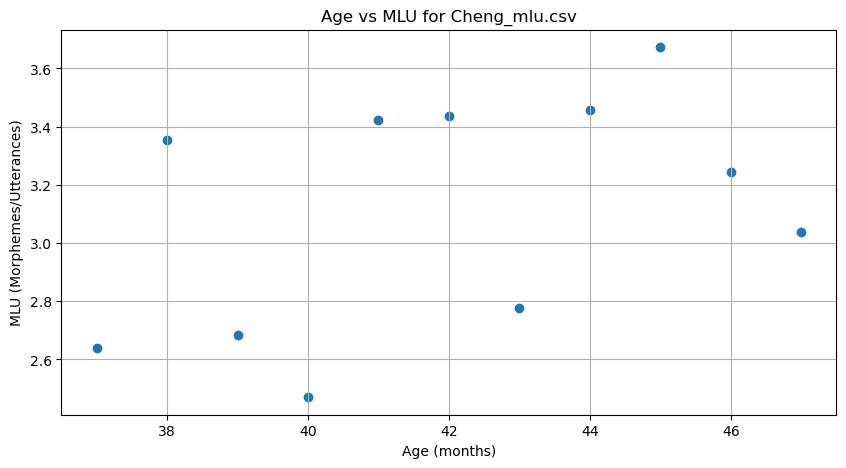

Spearman's rho for Cheng_mlu.csv: 0.4455

Chosen Transcripts for Cheng_mlu.csv: 
 ['030100.cha', '030200.cha', '030300.cha', '030400.cha', '030500.cha', '030600.cha', '030700.cha', '030800.cha', '030900.cha', '031000.cha', '031100.cha'] 

MLU Scores for Cheng_mlu.csv: 
 [2.64, 3.355, 2.683, 2.47, 3.423, 3.435, 2.775, 3.457, 3.673, 3.244, 3.039] 

Ages for Cheng_mlu.csv: 
 [37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0] 

Time Steps for Cheng_mlu.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



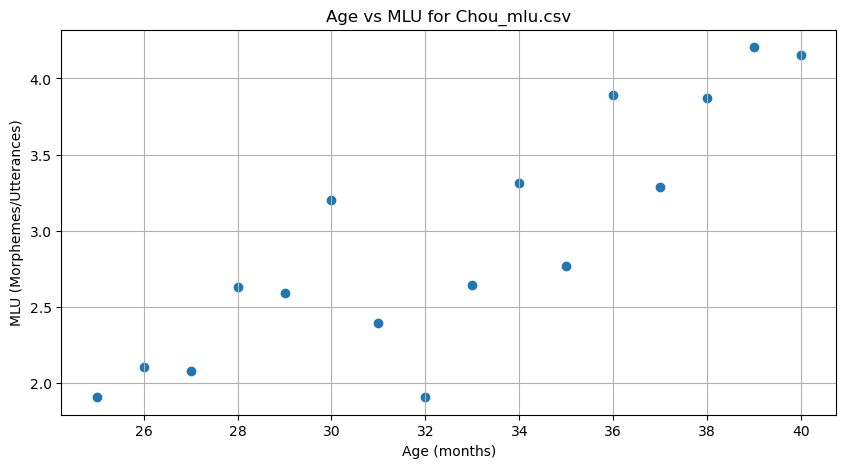

Spearman's rho for Chou_mlu.csv: 0.8676

Chosen Transcripts for Chou_mlu.csv: 
 ['020100.cha', '020200.cha', '020300.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '021000.cha', '021100.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha'] 

MLU Scores for Chou_mlu.csv: 
 [1.905, 2.102, 2.08, 2.632, 2.588, 3.202, 2.392, 1.908, 2.644, 3.314, 2.767, 3.893, 3.286, 3.873, 4.205, 4.156] 

Ages for Chou_mlu.csv: 
 [25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Chou_mlu.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



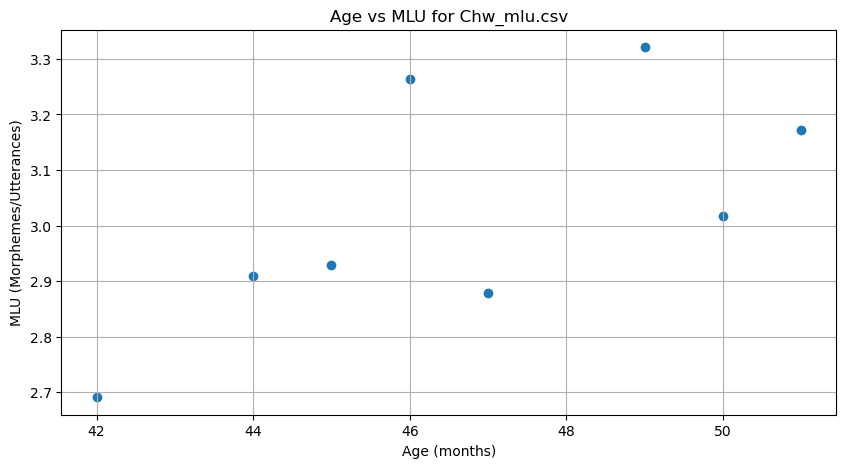

Spearman's rho for Chw_mlu.csv: 0.6190

Chosen Transcripts for Chw_mlu.csv: 
 ['030600.cha', '030800.cha', '030900.cha', '031000.cha', '031100.cha', '040100.cha', '040200.cha', '040300.cha'] 

MLU Scores for Chw_mlu.csv: 
 [2.691, 2.909, 2.929, 3.264, 2.878, 3.321, 3.018, 3.172] 

Ages for Chw_mlu.csv: 
 [42.0, 44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 51.0] 

Time Steps for Chw_mlu.csv: 
 [2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0] 



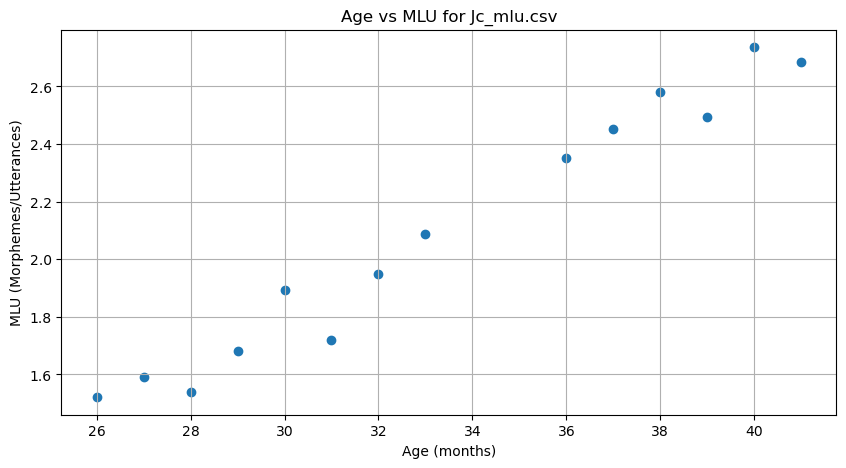

Spearman's rho for Jc_mlu.csv: 0.9824

Chosen Transcripts for Jc_mlu.csv: 
 ['020200.cha', '020300.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha', '030500.cha'] 

MLU Scores for Jc_mlu.csv: 
 [1.521, 1.592, 1.539, 1.683, 1.893, 1.72, 1.949, 2.088, 2.35, 2.451, 2.579, 2.494, 2.736, 2.684] 

Ages for Jc_mlu.csv: 
 [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0] 

Time Steps for Jc_mlu.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



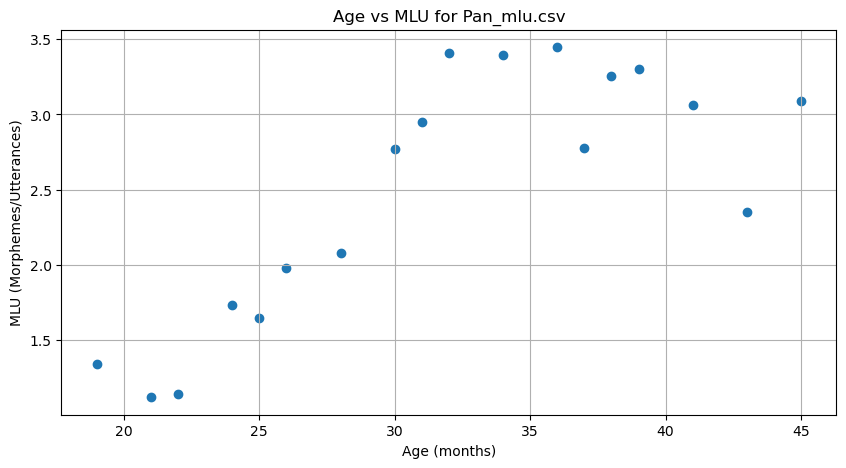

Spearman's rho for Pan_mlu.csv: 0.7379

Chosen Transcripts for Pan_mlu.csv: 
 ['010700.cha', '010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020600.cha', '020700.cha', '020800.cha', '021000.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030500.cha', '030700.cha', '030900.cha'] 

MLU Scores for Pan_mlu.csv: 
 [1.343, 1.122, 1.141, 1.734, 1.65, 1.981, 2.079, 2.772, 2.95, 3.406, 3.395, 3.446, 2.776, 3.257, 3.3, 3.064, 2.35, 3.092] 

Ages for Pan_mlu.csv: 
 [19.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 45.0] 

Time Steps for Pan_mlu.csv: 
 [2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0] 



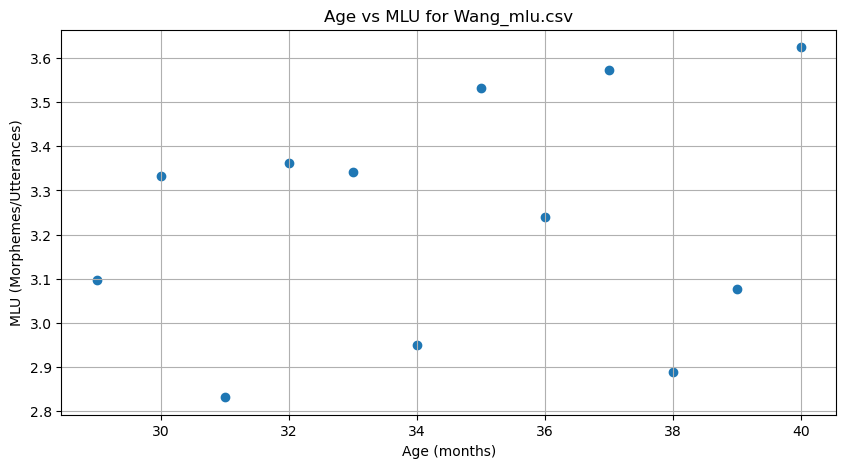

Spearman's rho for Wang_mlu.csv: 0.2378

Chosen Transcripts for Wang_mlu.csv: 
 ['020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '021000.cha', '021100.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha'] 

MLU Scores for Wang_mlu.csv: 
 [3.097, 3.332, 2.832, 3.362, 3.341, 2.951, 3.532, 3.24, 3.572, 2.89, 3.077, 3.624] 

Ages for Wang_mlu.csv: 
 [29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Wang_mlu.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



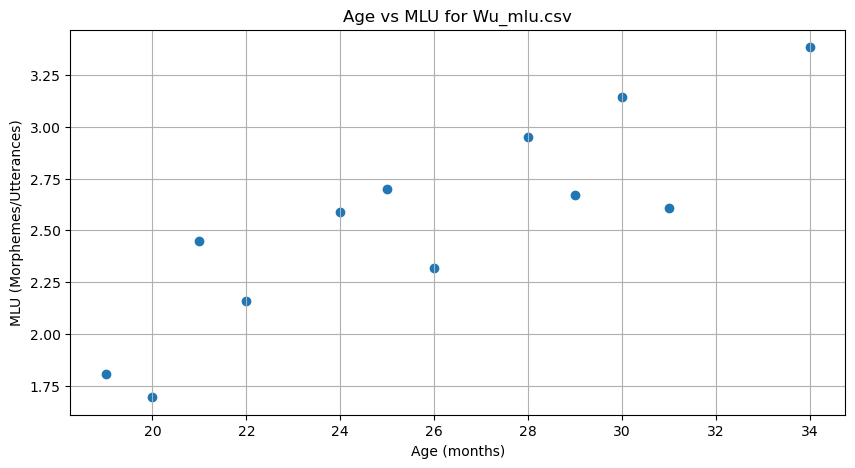

Spearman's rho for Wu_mlu.csv: 0.8322

Chosen Transcripts for Wu_mlu.csv: 
 ['010700.cha', '010800.cha', '010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '021000.cha'] 

MLU Scores for Wu_mlu.csv: 
 [1.806, 1.694, 2.446, 2.159, 2.587, 2.698, 2.319, 2.95, 2.67, 3.145, 2.606, 3.384] 

Ages for Wu_mlu.csv: 
 [19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 29.0, 30.0, 31.0, 34.0] 

Time Steps for Wu_mlu.csv: 
 [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0] 



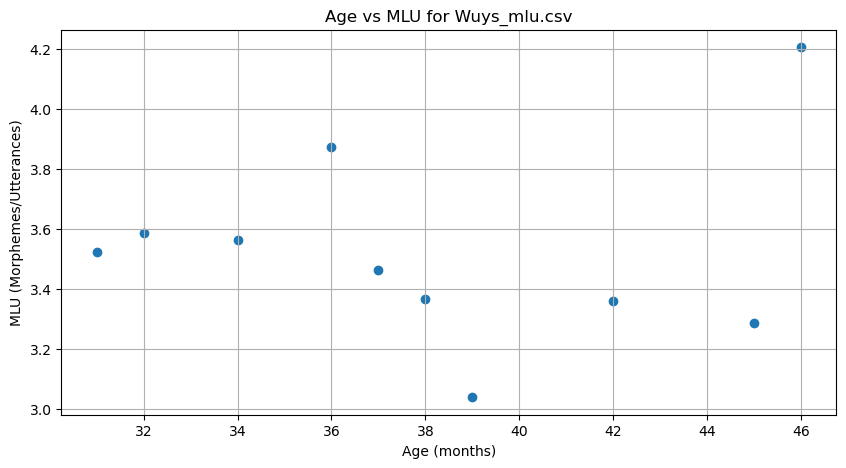

Spearman's rho for Wuys_mlu.csv: -0.3091

Chosen Transcripts for Wuys_mlu.csv: 
 ['020700.cha', '020800.cha', '021000.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030600.cha', '030900.cha', '031000.cha'] 

MLU Scores for Wuys_mlu.csv: 
 [3.523, 3.586, 3.565, 3.874, 3.464, 3.367, 3.04, 3.362, 3.286, 4.207] 

Ages for Wuys_mlu.csv: 
 [31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 45.0, 46.0] 

Time Steps for Wuys_mlu.csv: 
 [1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0] 



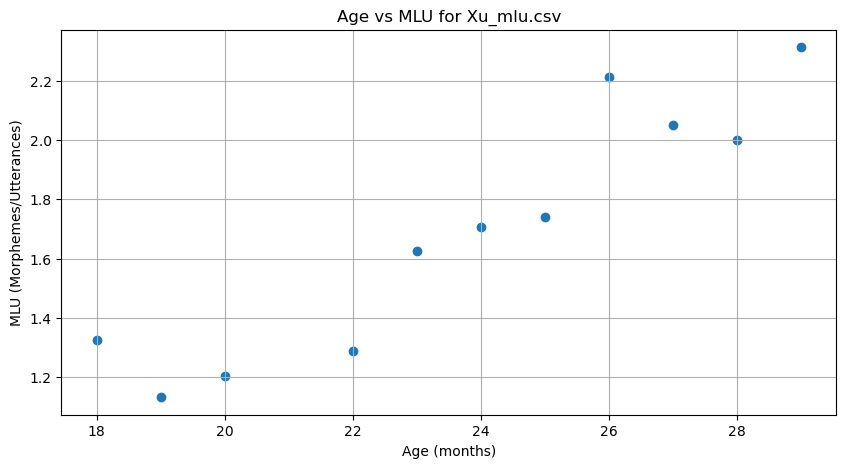

Spearman's rho for Xu_mlu.csv: 0.9091

Chosen Transcripts for Xu_mlu.csv: 
 ['010600.cha', '010700.cha', '010800.cha', '011000.cha', '011100.cha', '020000.cha', '020100.cha', '020200.cha', '020300.cha', '020400.cha', '020500.cha'] 

MLU Scores for Xu_mlu.csv: 
 [1.327, 1.133, 1.204, 1.288, 1.627, 1.707, 1.741, 2.214, 2.051, 2.0, 2.313] 

Ages for Xu_mlu.csv: 
 [18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0] 

Time Steps for Xu_mlu.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



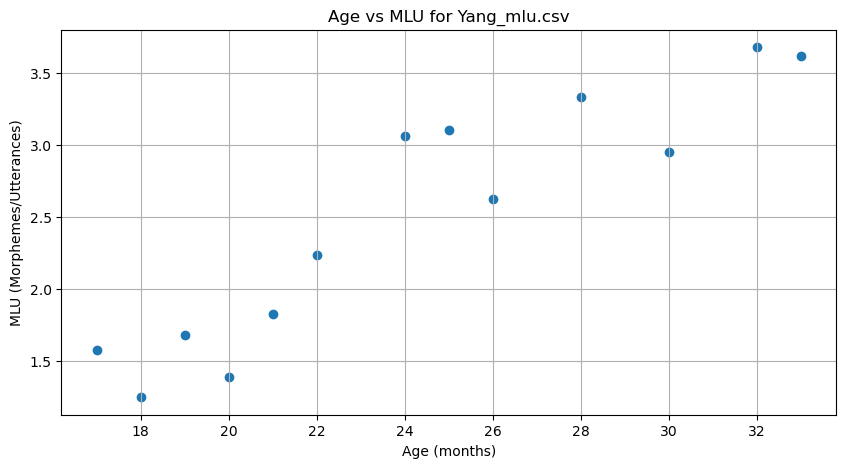

Spearman's rho for Yang_mlu.csv: 0.9066

Chosen Transcripts for Yang_mlu.csv: 
 ['010500.cha', '010600.cha', '010700.cha', '010800.cha', '010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020600.cha', '020800.cha', '020900.cha'] 

MLU Scores for Yang_mlu.csv: 
 [1.573, 1.247, 1.682, 1.391, 1.826, 2.237, 3.063, 3.109, 2.628, 3.336, 2.954, 3.682, 3.62] 

Ages for Yang_mlu.csv: 
 [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 32.0, 33.0] 

Time Steps for Yang_mlu.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0] 



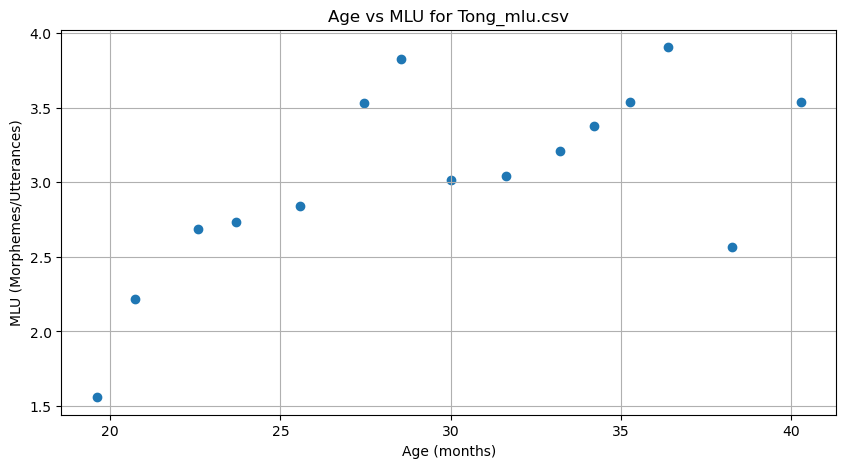

Spearman's rho for Tong_mlu.csv: 0.6143

Chosen Transcripts for Tong_mlu.csv: 
 ['010718.cha', '010822.cha', '011017.cha', '011121.cha', '020117.cha', '020314.cha', '020416.cha', '020530.cha', '020719.cha', '020906.cha', '021006.cha', '021108.cha', '030012.cha', '030208.cha', '030409.cha'] 

MLU Scores for Tong_mlu.csv: 
 [1.559, 2.218, 2.689, 2.732, 2.837, 3.528, 3.827, 3.015, 3.041, 3.207, 3.378, 3.537, 3.904, 2.563, 3.535] 

Ages for Tong_mlu.csv: 
 [19.6, 20.733333333333334, 22.566666666666666, 23.7, 25.566666666666666, 27.46666666666667, 28.53333333333333, 30.0, 31.633333333333333, 33.2, 34.2, 35.266666666666666, 36.4, 38.266666666666666, 40.3] 

Time Steps for Tong_mlu.csv: 
 [1.1333333333333329, 1.8333333333333321, 1.1333333333333329, 1.8666666666666671, 1.9000000000000021, 1.0666666666666629, 1.4666666666666686, 1.6333333333333329, 1.56666666666667, 1.0, 1.0666666666666629, 1.1333333333333329, 1.8666666666666671, 2.0333333333333314] 



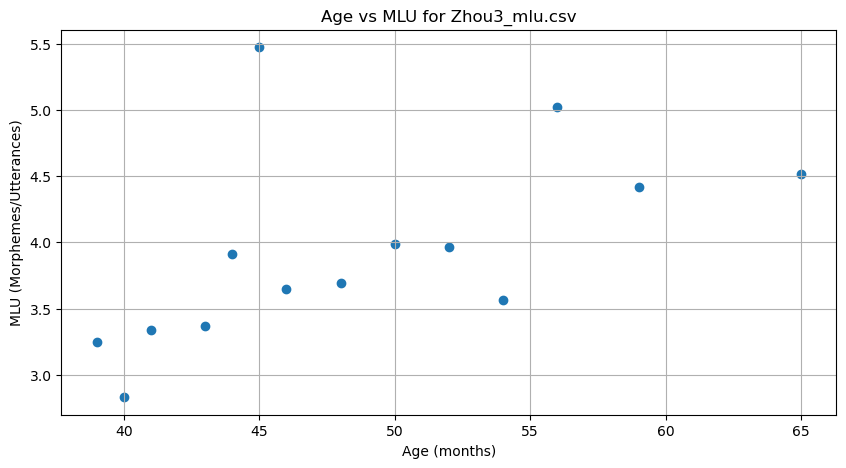

Spearman's rho for Zhou3_mlu.csv: 0.7275

Chosen Transcripts for Zhou3_mlu.csv: 
 ['000108.cha', '000227.cha', '000326.cha', '000506.cha', '000610.cha', '000702.cha', '000822.cha', '001005.cha', '001209.cha', '010218.cha', '010421.cha', '010630.cha', '010908.cha', '020323.cha'] 

MLU Scores for Zhou3_mlu.csv: 
 [3.246, 2.832, 3.337, 3.368, 3.909, 5.472, 3.649, 3.695, 3.99, 3.967, 3.569, 5.022, 4.417, 4.519] 

Ages for Zhou3_mlu.csv: 
 [39.0, 40.0, 41.0, 43.0, 44.0, 45.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 59.0, 65.0] 

Time Steps for Zhou3_mlu.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 6.0] 



In [12]:
age_mlu_plots(mlu_files_all, spearman_rhos_all, age_files)

## Spearman's ρ

In [13]:
spearman_rhos_50

[['Kang_mlu50.csv', 1.0],
 ['Laohu_mlu50.csv', -0.9999999999999999],
 ['Peng_mlu50.csv', 0.8999999999999998],
 ['Zhong_mlu50.csv', 0.9999999999999999],
 ['Cheng_mlu50.csv', 0.05454545454545456],
 ['Chou_mlu50.csv', 0.8088235294117646],
 ['Chw_mlu50.csv', 0.05988131309566295],
 ['Jc_mlu50.csv', 0.9472527472527472],
 ['Pan_mlu50.csv', 0.6449948400412797],
 ['Wang_mlu50.csv', 0.2867132867132868],
 ['Wu_mlu50.csv', 0.8511396590310907],
 ['Wuys_mlu50.csv', -0.01818181818181818],
 ['Xu_mlu50.csv', 0.8519384289712437],
 ['Yang_mlu50.csv', 0.7747252747252747],
 ['Tong_mlu50.csv', 0.666666932873275],
 ['Zhou3_mlu50.csv', 0.6292633070731976]]

In [14]:
spearman_rhos_100

[['Kang_mlu100.csv', 0.7999999999999999],
 ['Laohu_mlu100.csv', -0.9999999999999999],
 ['Peng_mlu100.csv', 0.7999999999999999],
 ['Zhong_mlu100.csv', 0.9999999999999999],
 ['Cheng_mlu100.csv', 0.16363636363636366],
 ['Chou_mlu100.csv', 0.8794117647058824],
 ['Chw_mlu100.csv', 0.09523809523809526],
 ['Jc_mlu100.csv', 0.9076923076923077],
 ['Pan_mlu100.csv', 0.651186790505676],
 ['Wang_mlu100.csv', 0.013986013986013986],
 ['Wu_mlu100.csv', 0.8391608391608393],
 ['Wuys_mlu100.csv', 0.05454545454545454],
 ['Xu_mlu100.csv', 0.9545454545454546],
 ['Yang_mlu100.csv', 0.8791208791208791],
 ['Tong_mlu100.csv', 0.657142857142857],
 ['Zhou3_mlu100.csv', 0.6791208791208792]]

In [15]:
spearman_rhos_all

[['Kang_mlu.csv', 1.0],
 ['Laohu_mlu.csv', -0.9999999999999999],
 ['Peng_mlu.csv', 0.6],
 ['Zhong_mlu.csv', 0.9999999999999999],
 ['Cheng_mlu.csv', 0.44545454545454555],
 ['Chou_mlu.csv', 0.8676470588235294],
 ['Chw_mlu.csv', 0.6190476190476191],
 ['Jc_mlu.csv', 0.9824175824175824],
 ['Pan_mlu.csv', 0.7378740970072238],
 ['Wang_mlu.csv', 0.2377622377622378],
 ['Wu_mlu.csv', 0.8321678321678322],
 ['Wuys_mlu.csv', -0.309090909090909],
 ['Xu_mlu.csv', 0.9090909090909091],
 ['Yang_mlu.csv', 0.9065934065934067],
 ['Tong_mlu.csv', 0.6142857142857142],
 ['Zhou3_mlu.csv', 0.7274725274725276]]